In [1]:
!date

Mon Mar 22 13:49:10 EDT 2021


# Time loop to track east coastal vapor lakes 

In [4]:
import sys
import os
import xarray as xr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import dask.array as da

from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Find the east coast of equatorial Afr-abia
### x-derivative of land mask, in 30-70, 20S-20N 

In [146]:
land_msk = xr.open_dataset('landmask_MERRA2.nc')
lm = land_msk.sel(lon=slice(30,100),lat=slice(-20,20))
lon = lm.lon.squeeze()
lat = lm.lat.squeeze()
lm

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 113, time: 1)
Coordinates:
  * lon      (lon) float64 30.0 30.62 31.25 31.88 ... 98.12 98.75 99.38 100.0
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... 18.5 19.0 19.5 20.0
  * time     (time) datetime64[ns] 1989-01-01T12:00:00
Data variables:
    lsm      (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.6.4 (http://code.zmaw.de/p...
    Conventions:  CF-1.6
    history:      Thu Nov 29 16:47:34 2018: cdo remapbil,mygrid landmask.nc l...
    CDO:          Climate Data Operators version 1.6.4 (http://code.zmaw.de/p...

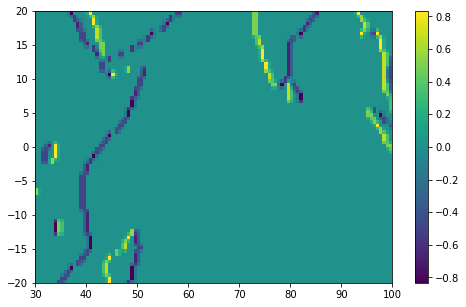

In [201]:
fig = plt.figure(figsize=(8,5))
plt.pcolor(lm.lon,lm.lat,lm.lsm.squeeze().diff("lon"))
plt.colorbar()

In [202]:
lm["eastcoast"] = xr.full_like(lm.lsm.diff("lon"), fill_value=0)

In [212]:
# Assign values in a spatial box
# https://xarray.pydata.org/en/stable/indexing.html#assigning-values-with-indexing

lc = lm.coords["lon"]
la = lm.coords["lat"]

locxxx = dict(lon=lc[(lc < 70) & (lc > 36)], lat=la[(la < 9999)])

lm["eastcoast"].loc[locxxx] = lm["lsm"].loc[locxxx].squeeze()

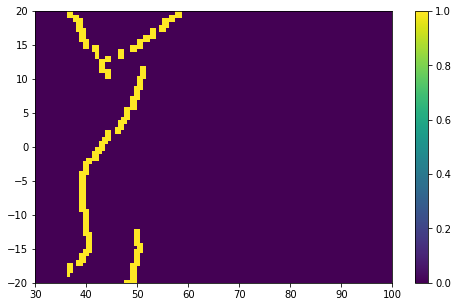

In [213]:
fig = plt.figure(figsize=(8,5))
plt.pcolor(lm.lon,lm.lat,lm.eastcoast.squeeze().diff("lon") <0 )
plt.colorbar()

# Planning: declare names, create output directories
------------

## Backward-in-time tracking of contours that reach the coast
See whiteboard in repo for ideas and sketches 

#### Shapefiles (contours as objects) are used for all lake margins and overlaps



-------------
## Outputs

#### All times (and thus filenames) are based on the time of *last* contact with the coastline (first encountered, in the reverse-time flow of the algorithm's time loop). 

#### The outputs are in one folder per year (to keep lengths moderate). 

The use of the output will be to 

    * screen events based on lines in `YYYY_lakes.txt` its concatenation across years
    
    * For selected events, further screen the hourly lines (e.g. to avoid times when any part of the lake are part of more than one coast-crossing vapor lake CCVL). 
    
    * Visualize CCVLs and their sub-lakes by placing shapefile contours on a geographical map, perhaps color-coded by time or by event number 
    

## Each year folder contains the following: 

### One file called `YYYY_lakes.txt` 
This is an index file, one line per lake, written when the lake-assignment algorithm terminates a lake ID. The line contains some bulk statistics that are updated (sums, maxima and minima) as the algo marches through the time levels. That line might be something like:

*YYYY-MM-DD-HH-ID, lats and first and last times of coast crossing, duration, easternmost longitude (100E for elements that break off the great warm pool vapor 'ocean'), integrated size (km^2-days), etc., etc.*

### One folder named `YYYY-MM-DD-HH-ID` per coast-crossing vapor lake

The folder contains

    * a NT-line txt file, one line per time level, with bulk stats of all the contours that make up the coast-crossing lake
    
    * a folder called `shapefiles`, which has NT files: one for each time level during which the lake exists. At each time level, that file may include more than one contour, in general.




----------
## Flow of the code
### Time loop, backward 

In working memory are always two arrays CWV(x,y), one called `now` and one called `prev`. Both are contoured at the selected level (say 50 mm), and the contours are available as inputs to a routine that evaluates the overlap of any two. Fixed long-skinny littoral contours are also available for this overlap evaluation. 

1. The coast contours are paired with every `now` CWV contour to seek overlap. If so, a new CCVL label is assigned to it, unless it already has a CCVL label. 

2. Every active CCVL label is looped over, and every one of its contours is looped over, and every contour in `prev` is looped over, seeking overlap. If there is overlap, the active CCVL label is appended to that contour in `prev`, and the contour is gathered into the set to be written into `YYYY-MM-DD-HH-ID/shapefiles/contours.cn` A contours can have multiple CCVL labels, and thus be copied or linked into multiple sets. 

2b. If that contour in `prev` has maxlon = 100E, the CCVL label is taken off the active list: the lake has been tracked back to the Great Lake. If this  occurs within step 1, this is an "atmospheric creek" or tentacle of vapor, not a "lake" at all. 

3. Within the loop 1. over active CCVL labels, a line is written to `YYYY/YYYY-MM-DD-HH-ID.txt`.

4. `prev` contours are transferred to `now`, a next (backward in time) CWV map is read in as `prev`, and the outer time loop repeats. 

# Open the data file of all time slices 

In [6]:
!ls -atlh /data2/brian/WEIO_30-100_20S-20N_2014-8.nc

-rw-rw-r-- 1 bmapes bmapes 755M Mar 10 18:55 /data2/brian/WEIO_30-100_20S-20N_2014-8.nc


In [7]:
TQV_WEIO = xr.open_dataset('/data2/brian/WEIO_30-100_20S-20N_2014-8.nc')
TQV_WEIO

<xarray.Dataset>
Dimensions:  (lat: 81, lon: 113, time: 43824)
Coordinates:
  * lat      (lat) float64 -20.0 -19.5 -19.0 -18.5 -18.0 ... 18.5 19.0 19.5 20.0
  * lon      (lon) float64 30.0 30.62 31.25 31.88 ... 98.12 98.75 99.38 100.0
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
Data variables:
    TQV      (time, lat, lon) float32 ...

# Start at the end and move backward one step